In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,precision_recall_curve, roc_curve, auc
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import english_nlp
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
import re

g:\OneDrive - northsouth.edu\CODES\PROJECTS\PROJECT - Bullishield Models\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\farha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Transformer model
class CyberBullyingClassifier(nn.Module):
    def __init__(self):
        super(CyberBullyingClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        probability = self.sigmoid(logits)
        return probability

In [4]:
# Create model instance
model = CyberBullyingClassifier()
model.to(device)

CyberBullyingClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [5]:
model.load_state_dict(torch.load('G:/OneDrive - northsouth.edu/CODES/PROJECTS/PROJECT - Bullishield Models/Created Models/english_bert.pth'))

<All keys matched successfully>

In [6]:
# loading data

try:
    all_data = pd.read_csv('english_hate_speech.csv')
    all_data.head()
except Exception as e:
    print(f"Error loading data: {e}")

print("Shape of the data: ", all_data.shape) #inspecting the shape of the data

Shape of the data:  (14490, 4)


In [7]:
def tokenise_text(data):
    """
    Tokenise the text in the clean_text column
    """
    try:
        # label changed to a float when imported, changing it back
        data['oh_label'] = data['oh_label'].astype(int)
        data['clean_text'] = data['clean_text'].astype(str)

        # also lowercasing all words
        data['tokens'] = data['clean_text'].apply(lambda x: [word.lower() for word in x.split()]) #ensures all text is lowercase
        print("Tokenisation successful")
        return data
    except Exception as e:
        print(f"Tokenisation error: {e}")
        return None

all_data = tokenise_text(all_data)
all_data.head()

Tokenisation successful


,Text,oh_label,Dataset,clean_text,tokens
0,I give permission for Wikipedia to use the ...,0,aggression_parsed_dataset_subset.csv,give permission Wikipedia use material Nancy S...,"[give, permission, wikipedia, use, material, n..."
1,` October 2010 (UTC) :::::It does look that wa...,0,toxicity_parsed_dataset_subset.csv,October 2010 UTC look way merger sounds like C...,"[october, 2010, utc, look, way, merger, sounds..."
2,RT @dcm81: #killerblondes ?? Have the producer...,0,twitter_parsed_dataset_subset.csv,RT dcm81 killerblondes producers lost plot eye...,"[rt, dcm81, killerblondes, producers, lost, pl..."
3,@ShaofHappiness COME SAY HI TO ME THIS EVENING...,0,twitter_parsed_dataset_subset.csv,ShaofHappiness COME SAY HI EVENING ILU,"[shaofhappiness, come, say, hi, evening, ilu]"
4,"@ManhattaKnight I mean he's gay, but he uses g...",1,cyberbullying_tweets_subset.csv,ManhattaKnight mean hes gay uses gendered slur...,"[manhattaknight, mean, hes, gay, uses, gendere..."


In [8]:

def lemmatize_text(data):
    """
    Lemmatises the tesxt data
    """
    try:
        lemm = WordNetLemmatizer() #using the inbuilt lemmatisation function

    # Lemmatize all words
        data['lemmatized'] = data['tokens'].apply(lambda x: [lemm.lemmatize(word) for word in x])
        print("Lemmatisation successful")
        return data
    except Exception as e:
        print(f"An error occurred during lemmatisation: {e}")
        return data

all_data=lemmatize_text(data=all_data)
all_data.head()

Lemmatisation successful


,Text,oh_label,Dataset,clean_text,tokens,lemmatized
0,I give permission for Wikipedia to use the ...,0,aggression_parsed_dataset_subset.csv,give permission Wikipedia use material Nancy S...,"[give, permission, wikipedia, use, material, n...","[give, permission, wikipedia, use, material, n..."
1,` October 2010 (UTC) :::::It does look that wa...,0,toxicity_parsed_dataset_subset.csv,October 2010 UTC look way merger sounds like C...,"[october, 2010, utc, look, way, merger, sounds...","[october, 2010, utc, look, way, merger, sound,..."
2,RT @dcm81: #killerblondes ?? Have the producer...,0,twitter_parsed_dataset_subset.csv,RT dcm81 killerblondes producers lost plot eye...,"[rt, dcm81, killerblondes, producers, lost, pl...","[rt, dcm81, killerblondes, producer, lost, plo..."
3,@ShaofHappiness COME SAY HI TO ME THIS EVENING...,0,twitter_parsed_dataset_subset.csv,ShaofHappiness COME SAY HI EVENING ILU,"[shaofhappiness, come, say, hi, evening, ilu]","[shaofhappiness, come, say, hi, evening, ilu]"
4,"@ManhattaKnight I mean he's gay, but he uses g...",1,cyberbullying_tweets_subset.csv,ManhattaKnight mean hes gay uses gendered slur...,"[manhattaknight, mean, hes, gay, uses, gendere...","[manhattaknight, mean, he, gay, us, gendered, ..."


In [9]:
def remove_numbers(word_list):
    """
    removees any numbers from the text
    """
    return [word for word in word_list if not bool(re.search(r'\d', word))]

# Function to remove URLs from a list of words
def remove_urls(word_list):
    """
    Removes any URLs from the text
    """
    return [word for word in word_list if not (word.startswith('http') or word.startswith('www') or word.startswith('https'))]

all_data['lemmatized_no_numbers'] = all_data['lemmatized'].apply(remove_numbers)
all_data['lemmatized_clean'] = all_data['lemmatized_no_numbers'].apply(remove_urls)

all_data['tokenized_clean']=all_data['tokens'].apply(remove_numbers)
all_data['tokenized_clean']=all_data['tokenized_clean'].apply(remove_urls)
all_data['string_tokenized']=all_data['tokenized_clean'].apply(' '.join)
all_data.head()

,Text,oh_label,Dataset,clean_text,tokens,lemmatized,lemmatized_no_numbers,lemmatized_clean,tokenized_clean,string_tokenized
0,I give permission for Wikipedia to use the ...,0,aggression_parsed_dataset_subset.csv,give permission Wikipedia use material Nancy S...,"[give, permission, wikipedia, use, material, n...","[give, permission, wikipedia, use, material, n...","[give, permission, wikipedia, use, material, n...","[give, permission, wikipedia, use, material, n...","[give, permission, wikipedia, use, material, n...",give permission wikipedia use material nancy s...
1,` October 2010 (UTC) :::::It does look that wa...,0,toxicity_parsed_dataset_subset.csv,October 2010 UTC look way merger sounds like C...,"[october, 2010, utc, look, way, merger, sounds...","[october, 2010, utc, look, way, merger, sound,...","[october, utc, look, way, merger, sound, like,...","[october, utc, look, way, merger, sound, like,...","[october, utc, look, way, merger, sounds, like...",october utc look way merger sounds like cathol...
2,RT @dcm81: #killerblondes ?? Have the producer...,0,twitter_parsed_dataset_subset.csv,RT dcm81 killerblondes producers lost plot eye...,"[rt, dcm81, killerblondes, producers, lost, pl...","[rt, dcm81, killerblondes, producer, lost, plo...","[rt, killerblondes, producer, lost, plot, eye,...","[rt, killerblondes, producer, lost, plot, eye,...","[rt, killerblondes, producers, lost, plot, eye...",rt killerblondes producers lost plot eyes fail...
3,@ShaofHappiness COME SAY HI TO ME THIS EVENING...,0,twitter_parsed_dataset_subset.csv,ShaofHappiness COME SAY HI EVENING ILU,"[shaofhappiness, come, say, hi, evening, ilu]","[shaofhappiness, come, say, hi, evening, ilu]","[shaofhappiness, come, say, hi, evening, ilu]","[shaofhappiness, come, say, hi, evening, ilu]","[shaofhappiness, come, say, hi, evening, ilu]",shaofhappiness come say hi evening ilu
4,"@ManhattaKnight I mean he's gay, but he uses g...",1,cyberbullying_tweets_subset.csv,ManhattaKnight mean hes gay uses gendered slur...,"[manhattaknight, mean, hes, gay, uses, gendere...","[manhattaknight, mean, he, gay, us, gendered, ...","[manhattaknight, mean, he, gay, us, gendered, ...","[manhattaknight, mean, he, gay, us, gendered, ...","[manhattaknight, mean, hes, gay, uses, gendere...",manhattaknight mean hes gay uses gendered slur...


In [10]:
# Split into training and temp (validation + test)
train_data, temp_data = train_test_split(all_data, test_size=0.4, random_state=42)  # 40% of data for temp

# Split temp into validation and test
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 50% of temp for each

In [11]:
# Tokenize the data
def tokenize_texts(texts, max_length):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    tokenized_texts = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return tokenized_texts

max_length=128

train_tokenized_texts = tokenize_texts(train_data['string_tokenized'].tolist(), max_length)
test_tokenized_texts = tokenize_texts(test_data['string_tokenized'].tolist(), max_length)
val_tokenized_texts = tokenize_texts(val_data['string_tokenized'].tolist(), max_length)


In [12]:
# Prepare train and test inputs and labels
train_inputs = {
    'input_ids': train_tokenized_texts['input_ids'],
    'attention_mask': train_tokenized_texts['attention_mask']
}

train_labels = torch.tensor(train_data['oh_label'].values,dtype=torch.float32).unsqueeze(1)

test_inputs = {
    'input_ids': test_tokenized_texts['input_ids'],
    'attention_mask': test_tokenized_texts['attention_mask']
}

test_labels = torch.tensor(test_data['oh_label'].values,dtype=torch.float32).unsqueeze(1)

val_inputs = {
    'input_ids': val_tokenized_texts['input_ids'],
    'attention_mask': val_tokenized_texts['attention_mask']
}

val_labels = torch.tensor(val_data['oh_label'].values,dtype=torch.float32).unsqueeze(1)

In [13]:
def evaluate_model(model, inputs, labels, device, batch_size=32):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for i in range(0, len(inputs['input_ids']), batch_size):
            batch_inputs = {key: val[i:i+batch_size].to(device) for key, val in inputs.items()}
            batch_labels = labels[i:i+batch_size].to(device)

            # Get model output, assuming it returns logits or probabilities directly
            outputs = model(**batch_inputs)

            # Convert model outputs to predictions (assuming binary classification)
            preds.extend(outputs.cpu().numpy())
            true_labels.extend(batch_labels.cpu().numpy())

    preds = np.array(preds)
    true_labels = np.array(true_labels)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, preds >= 0.5)
    precision = precision_score(true_labels, preds >= 0.5)
    recall = recall_score(true_labels, preds >= 0.5)
    f1 = f1_score(true_labels, preds >= 0.5)

    # Generate precision-recall curve
    precision_vals, recall_vals, _ = precision_recall_curve(true_labels, preds)
    pr_auc = auc(recall_vals, precision_vals)

    # Generate ROC curve
    fpr, tpr, _ = roc_curve(true_labels, preds)
    roc_auc = auc(fpr, tpr)

    # Plot Precision-Recall Curve
    plt.figure(figsize=(10, 5))
    plt.plot(recall_vals, precision_vals, label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

    # Plot ROC Curve
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return accuracy, precision, recall, f1


g:\OneDrive - northsouth.edu\CODES\PROJECTS\PROJECT - Bullishield Models\venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


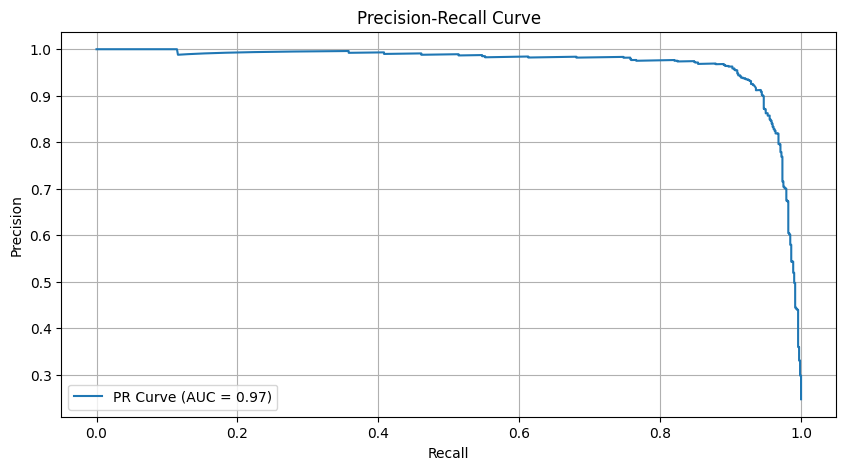

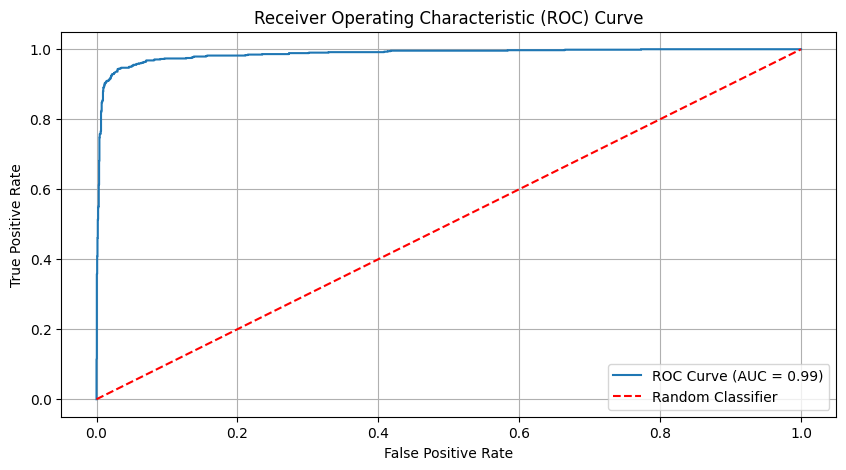

Validation Accuracy: 0.9648
Validation Precision: 0.9375
Validation Recall: 0.9192
Validation F1 Score: 0.9283


In [14]:
# Evaluate the model on the validation set
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, val_inputs, val_labels, device)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')

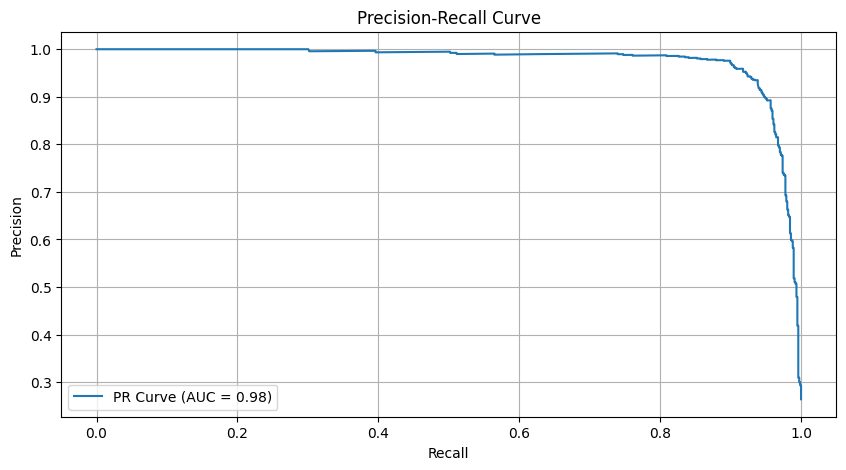

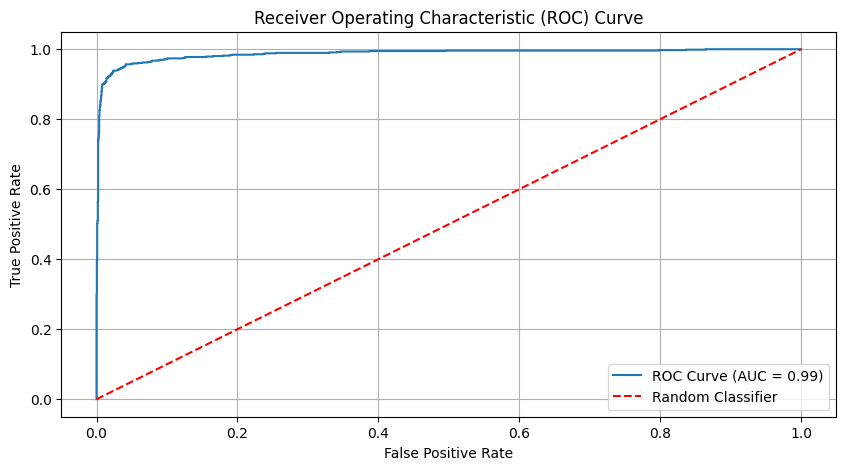

Test Accuracy: 0.9651
Test Precision: 0.9380
Test Recall: 0.9294
Test F1 Score: 0.9337


In [15]:
# Evaluate the model on the test set
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_inputs, test_labels, device)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')